# 0. Imports, configs y checks

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # un poco menos de warnings de tensorflow
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async" # intento de liberar VRAM
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # deshabilitar la dGPU

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt
#import plotly.express as px

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
import tensorflow as tf

# pandas para el csv
import pandas as pd

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

E0000 00:00:1730933466.568428   58057 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730933466.573649   58057 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Ver si detecta la GPU en caso de haberla
gpus = tf.config.list_physical_devices("GPU")

if gpus:
 for gpu in gpus:
    print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Análisis exploratorio sobre el conjunto de datos

In [5]:
# lo vamos a estar usando seguido
CATEGORIES = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./train')
TEST_DIR = Path('./test')
VALIDATION_DIR = Path('./validation')
SIZE = 150

Creamos datasets para Keras:

In [6]:
images_reader = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    #vertical_flip=True,
)

READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CATEGORIES,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

In [7]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

Found 8159 images belonging to 6 classes.
Found 5200 images belonging to 6 classes.


## Volumetría de los datos

El dataset de train y test cuenta con imágenes de escenas naturales de todo el mundo, train contiene 14034 imágenes y el dataset de test cuenta con 3000 imágenes, dando un total de 258 MB train y test juntos.
Las imagenes se dividiran en 6 categorias:

* "buildings": imagenes de edificios
* "forest": imagenes de bosques en diferentes estaciones y ambientes
* "glacier": imagenes de paisajes nevados
* "mountain": imagenes de montañas en distintos ambientes
* "sea": imagenes sobre oceanos y playas
* "street": imagenes de paisaje urbano

In [6]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CATEGORIES[np.argmax(labels[i])])
        plt.axis("off")

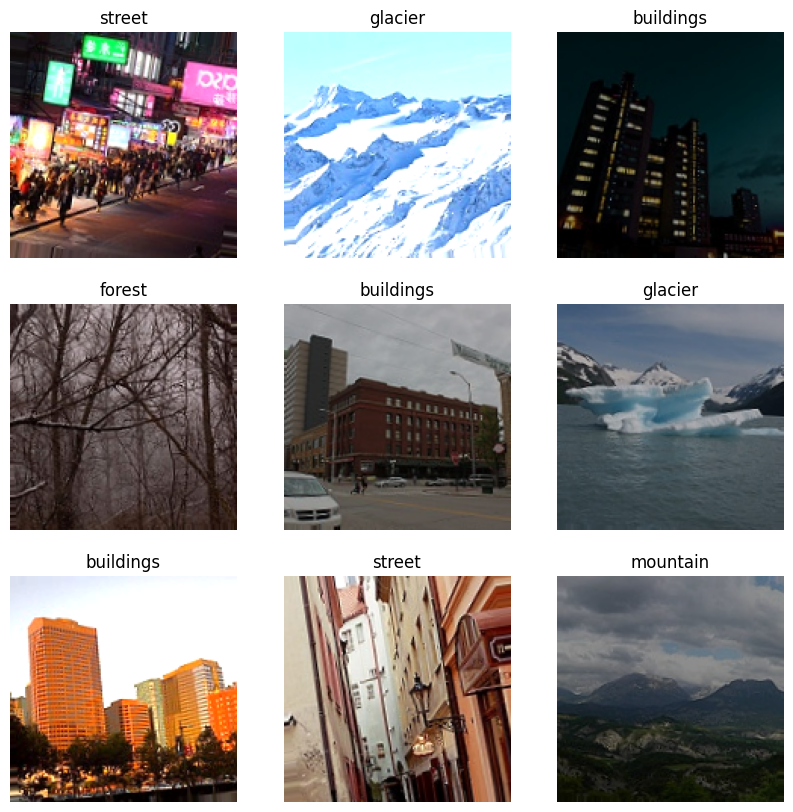

In [7]:
sample_images(train)

Luego de revisar brevemente las carpetas, observamos que existen varias imagenes que difieren de las categorias, y decidimos eliminarlas del dataset de train, puesto que estas imagenes pueden tener un impacto negativo a la hora de entrenar

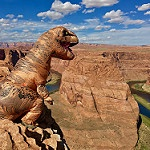

In [4]:
#mostrar imagen del dino
tf.keras.utils.load_img("./train/glacier/1512.jpg")

aaah yes... a glacier...

Por ultimo, decidimos dividir la carpeta de train para crear una carpeta de validation, mediante el uso de un script externo "trainValidationSplit.sh"

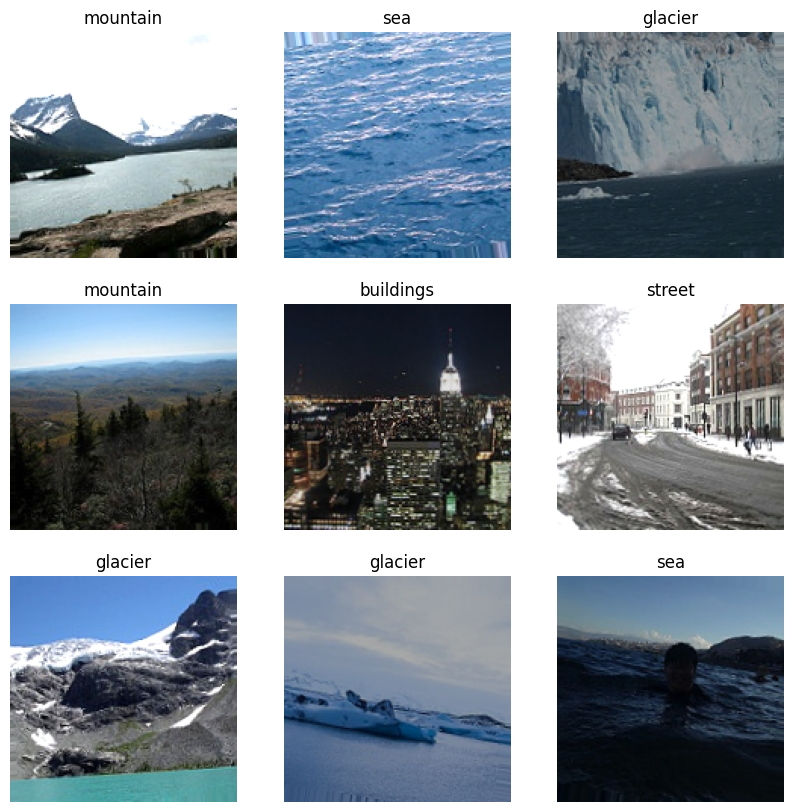

In [8]:
sample_images(validation)

## Estructura y tipo de las imágenes

Las imagenes:
* tienen una dimension de 150x150
* todas son del tipo "jpg"

## Distribución de la variable a predecir

Primero contamos con una carpeta "train" que contiene carpetas por cada  categoria de imagen

In [9]:
root_path = "./train"

contents = os.listdir(root_path)

# Loop through each item in the list
for item in contents:
    # Check if the item is a directory
    if os.path.isdir(os.path.join(root_path, item)):
        print("Found directory:", item)

Found directory: street
Found directory: glacier
Found directory: sea
Found directory: buildings
Found directory: mountain
Found directory: forest


Vemos la cantidad de imagenes que existe en la carpeta train

In [10]:
num_images = 0
for dirpath, dirnames, filenames in os.walk(root_path):
    # Count the number of image files in the current subdirectory
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            num_images += 1

    # Print the number of image files in the current subdirectory
    print(f"Found {num_images} images in directory: {dirpath}")
    num_images = 0

Found 0 images in directory: ./train
Found 1462 images in directory: ./train/street
Found 1355 images in directory: ./train/glacier
Found 1273 images in directory: ./train/sea
Found 1249 images in directory: ./train/buildings
Found 1476 images in directory: ./train/mountain
Found 1344 images in directory: ./train/forest


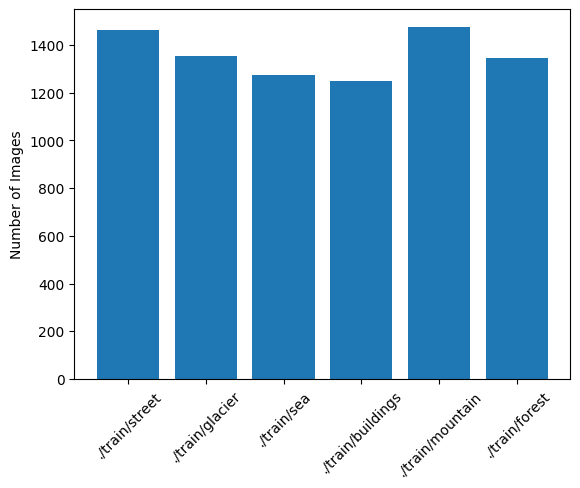

In [12]:
subdirectories = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.show()

Podemos ver que existe un balance entre clases, con poca diferencia entre las mismas, lo que favorece al entrenamiento.

# 2. Modelado

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, LeakyReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16, VGG19, Xception

Recursos consultados:
* https://keras.io/api/applications/
* https://keras.io/api/applications/xception/
* https://keras.io/guides/transfer_learning/

### Funciones y variables

In [9]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)

In [10]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [11]:
datasets = (
    ('train', images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS, batch_size=-1)),
    ('validation', images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS, batch_size=-1)),
)

def show_confusion_matrix(model):
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)
    
        batch_images, batch_labels = next(dataset)
        
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        predictions = np.argmax(model.predict(batch_images), axis=-1)
        labels = np.argmax(batch_labels, axis=-1)
        
        print('Accuracy:', accuracy_score(labels, predictions))
    
        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))
            
        plt.xticks([0, 1, 2, 3, 4, 5], CATEGORIES, rotation=45)
        plt.yticks([0, 1, 2, 3, 4, 5], CATEGORIES)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')
    
        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )
    
        plt.show()

Found 8159 images belonging to 6 classes.
Found 5200 images belonging to 6 classes.


In [12]:
def compile_summarize(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy',],
    )
    model.summary()

In [13]:
def accuracy_over_epochs(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [14]:
def fit_model(model, n_epochs=5):
    return model.fit(
        train,
        epochs=n_epochs,
        batch_size=128,
        validation_data=validation,
        callbacks=[OurCustomCallback()]
    )

In [15]:
# no parecería andar
# gc.collect() y del (modelo) tampoco
# con suerte la env var de la primer celda hace algo por el lado de CUDA
# https://github.com/tensorflow/tensorflow/issues/48545
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-2276233833
def clear_vram():
    tf.keras.backend.clear_session(free_memory=True)

### Entrenamientos

#### MLP Simple

Se realiza este entrenamiento a modo de tener una base y por completitud, no se espera que de buenos resultados

In [ ]:
clear_vram()
model_mlp = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

In [ ]:
compile_summarize(model_mlp)

In [ ]:
history_mlp = fit_model(model_mlp)

In [ ]:
accuracy_over_epochs(history_mlp)

In [ ]:
model_mlp.set_weights(model_weights_at_epochs[4])

In [ ]:
show_confusion_matrix(model_mlp)

#### Convolucional

Modelo convolucional con arquitectura default

In [ ]:
clear_vram()
model_convolutional = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

In [ ]:
compile_summarize(model_convolutional)

In [ ]:
history_convolutional = fit_model(model_convolutional)

In [ ]:
accuracy_over_epochs(history_convolutional)

In [ ]:
model_convolutional.set_weights(model_weights_at_epochs[4])

In [ ]:
show_confusion_matrix(model_convolutional)

#### Convolucional VGG16

Modelo convolucional que integra el modelo preentrenado VGG16

In [ ]:
clear_vram()
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_vgg16 = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

In [ ]:
compile_summarize(model_vgg16)

In [ ]:
history_vgg16 = fit_model(model_vgg16)

In [ ]:
accuracy_over_epochs(history_vgg16)

In [ ]:
model_vgg16.set_weights(model_weights_at_epochs[1])

In [ ]:
show_confusion_matrix(model_vgg16)

#### Convolucional VGG16 - LeakyReLU

Modelo convolucional integrando VGG16 con capas LeakyReLU

In [40]:
clear_vram()
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_vgg16_leaky = Sequential([
    pretrained_model,

    Flatten(),
    
    Dense(256),
    LeakyReLU(negative_slope=0.1),  
    Dropout(0.25),
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.25),
    Dense(100),
    LeakyReLU(negative_slope=0.1),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

In [32]:
compile_summarize(model_vgg16_leaky)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,858,498 (64.31 MB)

 Trainable params: 2,143,810 (8.18 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
history_vgg16_leaky = fit_model(model_vgg16_leaky)

Epoch 1/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 153s 592ms/step - accuracy: 0.6760 - loss: 0.8365 - val_accuracy: 0.8431 - val_loss: 0.4224
Epoch 2/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 48s 186ms/step - accuracy: 0.8381 - loss: 0.4335 - val_accuracy: 0.8377 - val_loss: 0.4107
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 48s 186ms/step - accuracy: 0.8562 - loss: 0.3896 - val_accuracy: 0.8687 - val_loss: 0.3602
Epoch 4/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.8724 - loss: 0.3481 - val_accuracy: 0.8677 - val_loss: 0.3751
Epoch 5/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 49s 192ms/step - accuracy: 0.8726 - loss: 0.3340 - val_accuracy: 0.8671 - val_loss: 0.3550


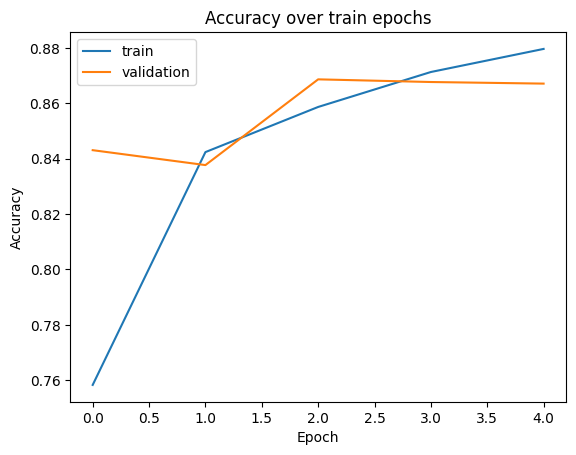

In [34]:
accuracy_over_epochs(history_vgg16_leaky)

In [37]:
model_vgg16_leaky.set_weights(model_weights_at_epochs[2])

In [ ]:
show_confusion_matrix(model_vgg16_leaky)

#### Convolucional Xception

In [16]:
clear_vram()
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
pretrained_model.trainable = False

model_xception = Sequential([
    pretrained_model,

    Flatten(),
    
    Dense(256),
    LeakyReLU(negative_slope=0.1),  
    Dropout(0.25),
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.25),
    Dense(100),
    LeakyReLU(negative_slope=0.1),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

I0000 00:00:1730934116.797937   58057 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1730934116.798934   58057 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2837 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


/home/iza/.conda/envs/ml/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [17]:
compile_summarize(model_xception)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,015,338 (129.76 MB)

 Trainable params: 13,153,858 (50.18 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [20]:
history_xception = fit_model(model_xception, 10)

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.9047 - loss: 0.2884 - val_accuracy: 0.9065 - val_loss: 0.2649
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.9041 - loss: 0.2667 - val_accuracy: 0.9117 - val_loss: 0.2529
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.9065 - loss: 0.2531 - val_accuracy: 0.9104 - val_loss: 0.2681
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.9055 - loss: 0.2626 - val_accuracy: 0.9158 - val_loss: 0.2709
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - accuracy: 0.9126 - loss: 0.2347 - val_accuracy: 0.9067 - val_loss: 0.2593
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.9142 - loss: 0.2333 - val_accuracy: 0.9090 - val_loss: 0.3130
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.9256 - loss: 0.2111 - val_accuracy: 0.9152 - val_loss: 0.2401
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 183ms/step - accuracy: 0.9221 - loss: 0

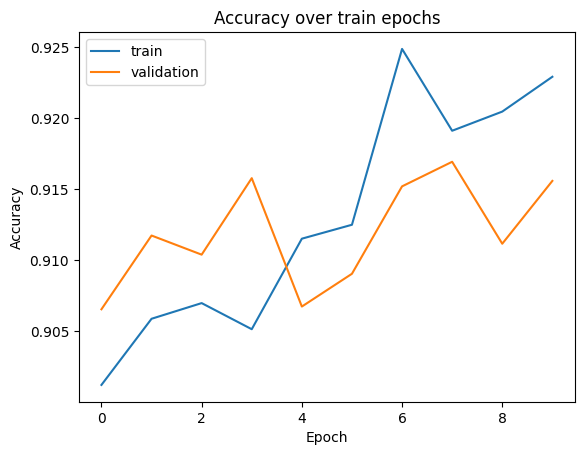

In [21]:
accuracy_over_epochs(history_xception)

In [22]:
model_xception.set_weights(model_weights_at_epochs[7])

######################### train #########################
255/255 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step
Accuracy: 0.9443491051728364


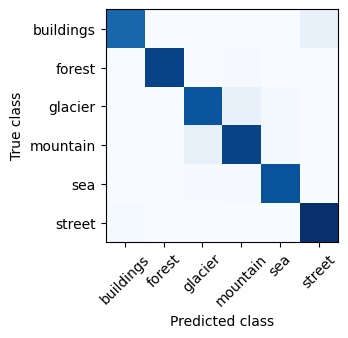

######################### validation #########################
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step
Accuracy: 0.9219080592421619


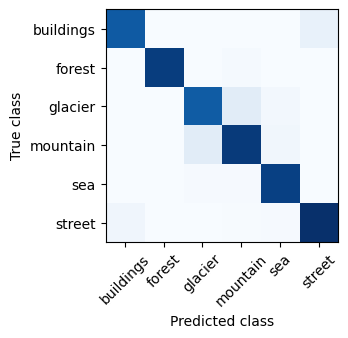

In [23]:
show_confusion_matrix(model_xception)

# 3. Conclusiones

# 4. Competencia

Creación de archivos CSV para la submission

In [24]:
CSV_FILENAME = "ConvolutionalXceptionLeaky"
MODEL = model_xception

images = []
labels = []

for image in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, image)
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    images.append(image_array)

inputs = np.array(images) / 255.0

predictions = MODEL.predict(inputs)

for i, filename in enumerate(os.listdir(TEST_DIR)):
    predicted_label = CATEGORIES[np.argmax(predictions[i])]
    labels.append([filename, predicted_label])

df = pd.DataFrame(labels, columns=["ID", "Label"])
df.to_csv("./submissions/"+CSV_FILENAME+".csv", index=False)
print("CSV exported successfully.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step
CSV exported successfully.
